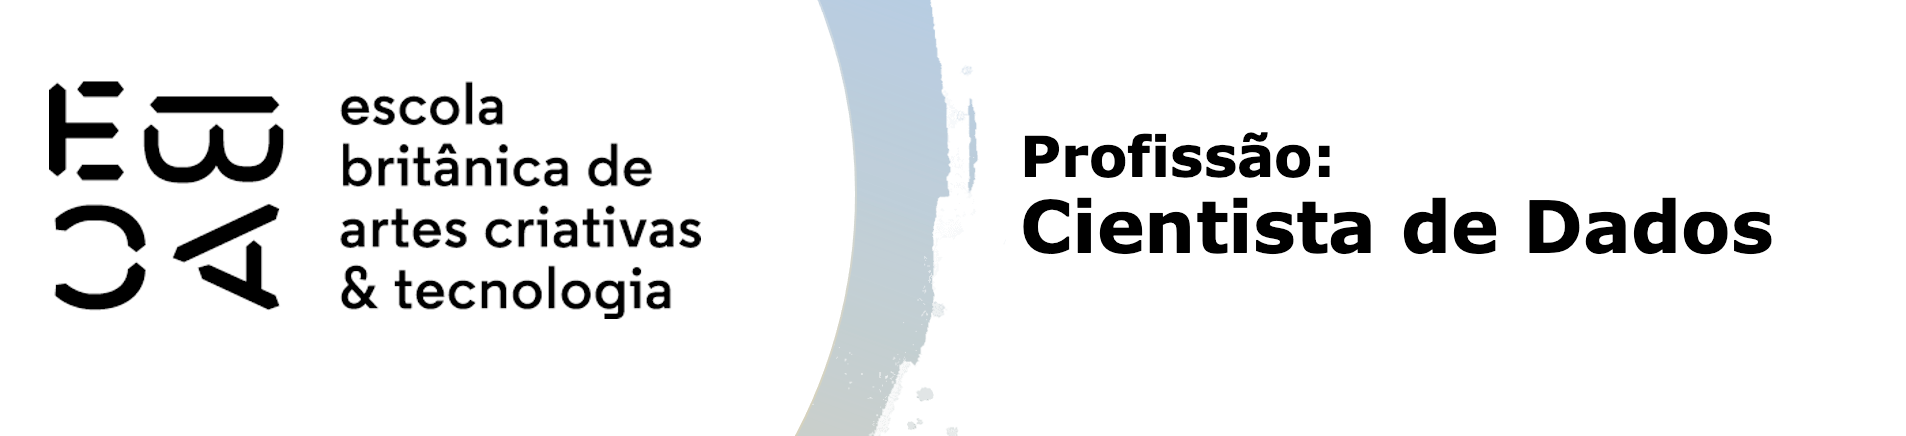

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
%matplotlib inline


In [119]:
class AvaliacaoInicial:
    
    def __init__(self):
        self.data = self.importar()
    
    def importar(self):
        df = pd.read_csv('./Dados/previsao_de_renda_II.csv')
        # Extrair mês de referência
        df['data_ref'] = pd.to_datetime(df['data_ref'])
        df['mês'] = df['data_ref'].dt.month
        # Remover coluna índice
        df.drop(['index','data_ref'],axis=1, inplace=True)
        # Transformar a variável renda para log
        df['renda'] = np.log(df['renda'])
        # Preenchendo os vazios
        df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].mean())
        
        df['qtd_filhos'] = df['qtd_filhos'].apply(lambda x: 4 if x>=4 else x)
        
        df['qt_pessoas_residencia'] = df['qt_pessoas_residencia'].apply(lambda x: 5 if x>=5 else x)
        #categorizar numéricos
        df['idade_cat'] = pd.qcut(df['idade'], q=4).astype(str)
        df['tempo_emprego_cat'] = pd.qcut(df['tempo_emprego'], q=6).astype(str)
        return df
    
    def modelo(self):

        # Selecionar Variaveis
        num = "+ tempo_emprego"
        cat = "C(sexo) + C(posse_de_imovel) + C(tipo_renda) + C(mês)"
        variaveis = f"renda ~ {cat} {num}"
        # Criar modelo
        modelo = smf.ols(variaveis, data=self.data).fit()
        return modelo
    
    def predict(self):
        
        # Selecionar Variaveis
        num = "+ tempo_emprego"
        cat = "C(sexo) + C(posse_de_imovel) + C(tipo_renda) + C(mês)"
        variaveis = f"renda ~ {cat} {num}"
        # Criar modelo
        modelo = smf.ols(variaveis, data=self.data).fit()
        return modelo.predict()
    
    def influencia(self):
        # Selecionar Variaveis
        num = "+ tempo_emprego"
        cat = "C(sexo) + C(posse_de_imovel) + C(tipo_renda) + C(mês)"
        variaveis = f"renda ~ {cat} {num}"
        # Criar modelo
        modelo = smf.ols(variaveis, data=self.data).fit()
        
        influencia = modelo.get_influence()

        # Obtenha os resíduos padronizados
        residuos_padronizados = influencia.resid_studentized

        # Obter a matriz de alavancagem
        leverage = modelo.get_influence().hat_matrix_diag
        sns.scatterplot(y=residuos_padronizados, x=leverage, alpha=0.2)
        plt.show()
        return leverage
        
    def hl_modelo(self, sumario):
        
        tabela = pd.DataFrame(sumario.tables[1], columns = ['Atributos','coef','std','t','P>|t|','[0.025','0.975'])
        tabela.drop(0,axis=0, inplace=True)        
        for i in tabela:
            tabela[i] = tabela[i].astype(str).astype(str)
       # tabela.set_index('Atributos',inplace=True)
        tabela.set_index('Atributos', inplace=True)
        for i in tabela:
            tabela[i] = tabela[i].astype(str).astype(float)

        display(tabela.style.highlight_between(left=0, right=0.1,subset='P>|t|'))

In [3]:
df = AvaliacaoInicial().data

In [4]:
df.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mês,idade_cat,tempo_emprego_cat
0,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,9.318131,1,"(43.0, 53.0]","(11.712, 42.907]"
1,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,7.793508,1,"(21.999, 34.0]","(7.746, 11.712]"
2,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,9.528769,1,"(21.999, 34.0]","(7.746, 11.712]"
3,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,7.767196,1,"(43.0, 53.0]","(0.11699999999999999, 2.367]"
4,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,6.673020,1,"(21.999, 34.0]","(0.11699999999999999, 2.367]"


In [41]:
%%time 
m = AvaliacaoInicial().modelo()

CPU times: total: 13.8 s
Wall time: 10.4 s


In [42]:
m.summary().tables[0]

Dep. Variable:,renda,R-squared:,0.658
Model:,OLS,Adj. R-squared:,0.658
Method:,Least Squares,F-statistic:,8.014e+04
Date:,"Fri, 15 Dec 2023",Prob (F-statistic):,0.00
Time:,09:39:24,Log-Likelihood:,-8.4951e+05
No. Observations:,750000,AIC:,1.699e+06
Df Residuals:,749981,BIC:,1.699e+06
Df Model:,18,,
Covariance Type:,nonrobust,,


In [36]:
AvaliacaoInicial().hl_modelo(m.summary())

,coef,std,t,P>|t|,[0.025,0.975
Atributos,,,,,,
Intercept,7.117700,0.004000,2025.602000,0.000000,7.111000,7.125000
C(sexo)[T.M],0.124600,0.002000,65.574000,0.000000,0.121000,0.128000
C(posse_de_imovel)[T.S],0.191400,0.002000,103.122000,0.000000,0.188000,0.195000
C(tipo_renda)[T.Bolsista],-0.170800,0.039000,-4.408000,0.000000,-0.247000,-0.095000
C(tipo_renda)[T.Empresário],0.150300,0.002000,68.844000,0.000000,0.146000,0.155000
C(tipo_renda)[T.Pensionista],-0.218400,0.007000,-29.149000,0.000000,-0.233000,-0.204000
C(tipo_renda)[T.Servidor público],0.140900,0.003000,43.823000,0.000000,0.135000,0.147000
C(mês)[T.2],0.032100,0.003000,9.555000,0.000000,0.026000,0.039000
C(mês)[T.3],0.124100,0.003000,36.972000,0.000000,0.118000,0.131000


## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

In [44]:
# Curtose e Assimetria para avaliar a normalidade da distribuição
m.summary().tables[2]

Omnibus:,129.589,Durbin-Watson:,1.840
Prob(Omnibus):,0.000,Jarque-Bera (JB):,138.105
Skew:,-0.003,Prob(JB):,1.03e-30
Kurtosis:,3.066,Cond. No.,442.


<Axes: ylabel='Count'>

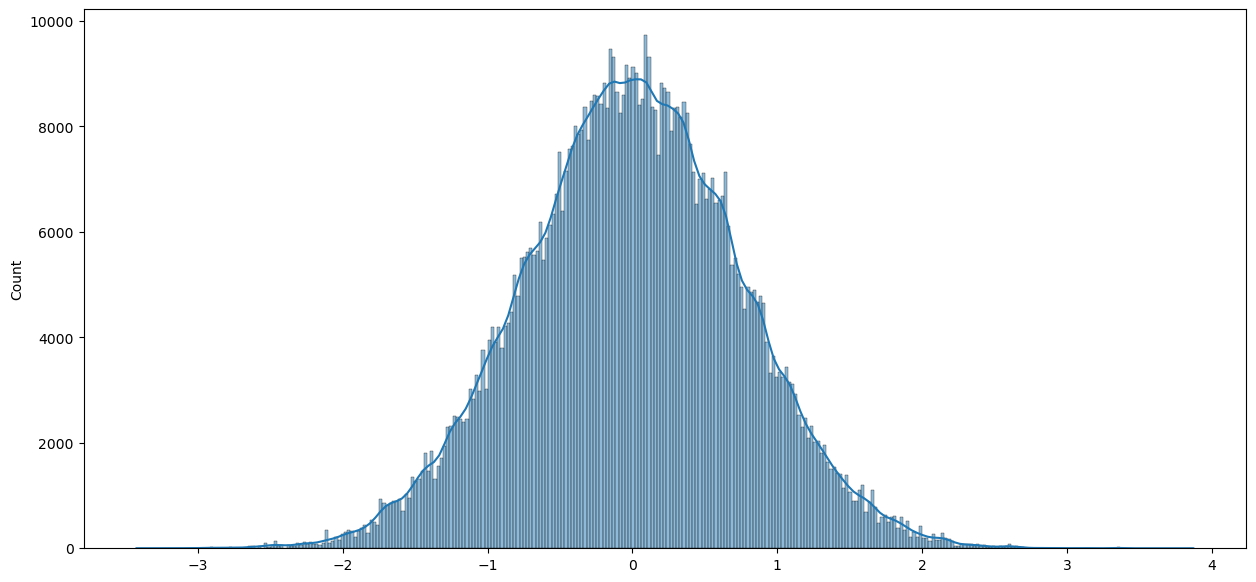

In [50]:
# Distribuição dos resíduos
plt.figure(figsize=(15,7))
sns.histplot(m.resid, kde=True)

- Olhando a simetria (skew) e visualizando a figura acima, percebe-se que os resíduos tem uma distribuição próxima ao normal, sendo um ponto de observação a curtose (kurtosis) que está positiva significando que a concentração no meio é mais elevada do que seria em uma normal, mas o valor ainda é baixo, nada muito alarmante.

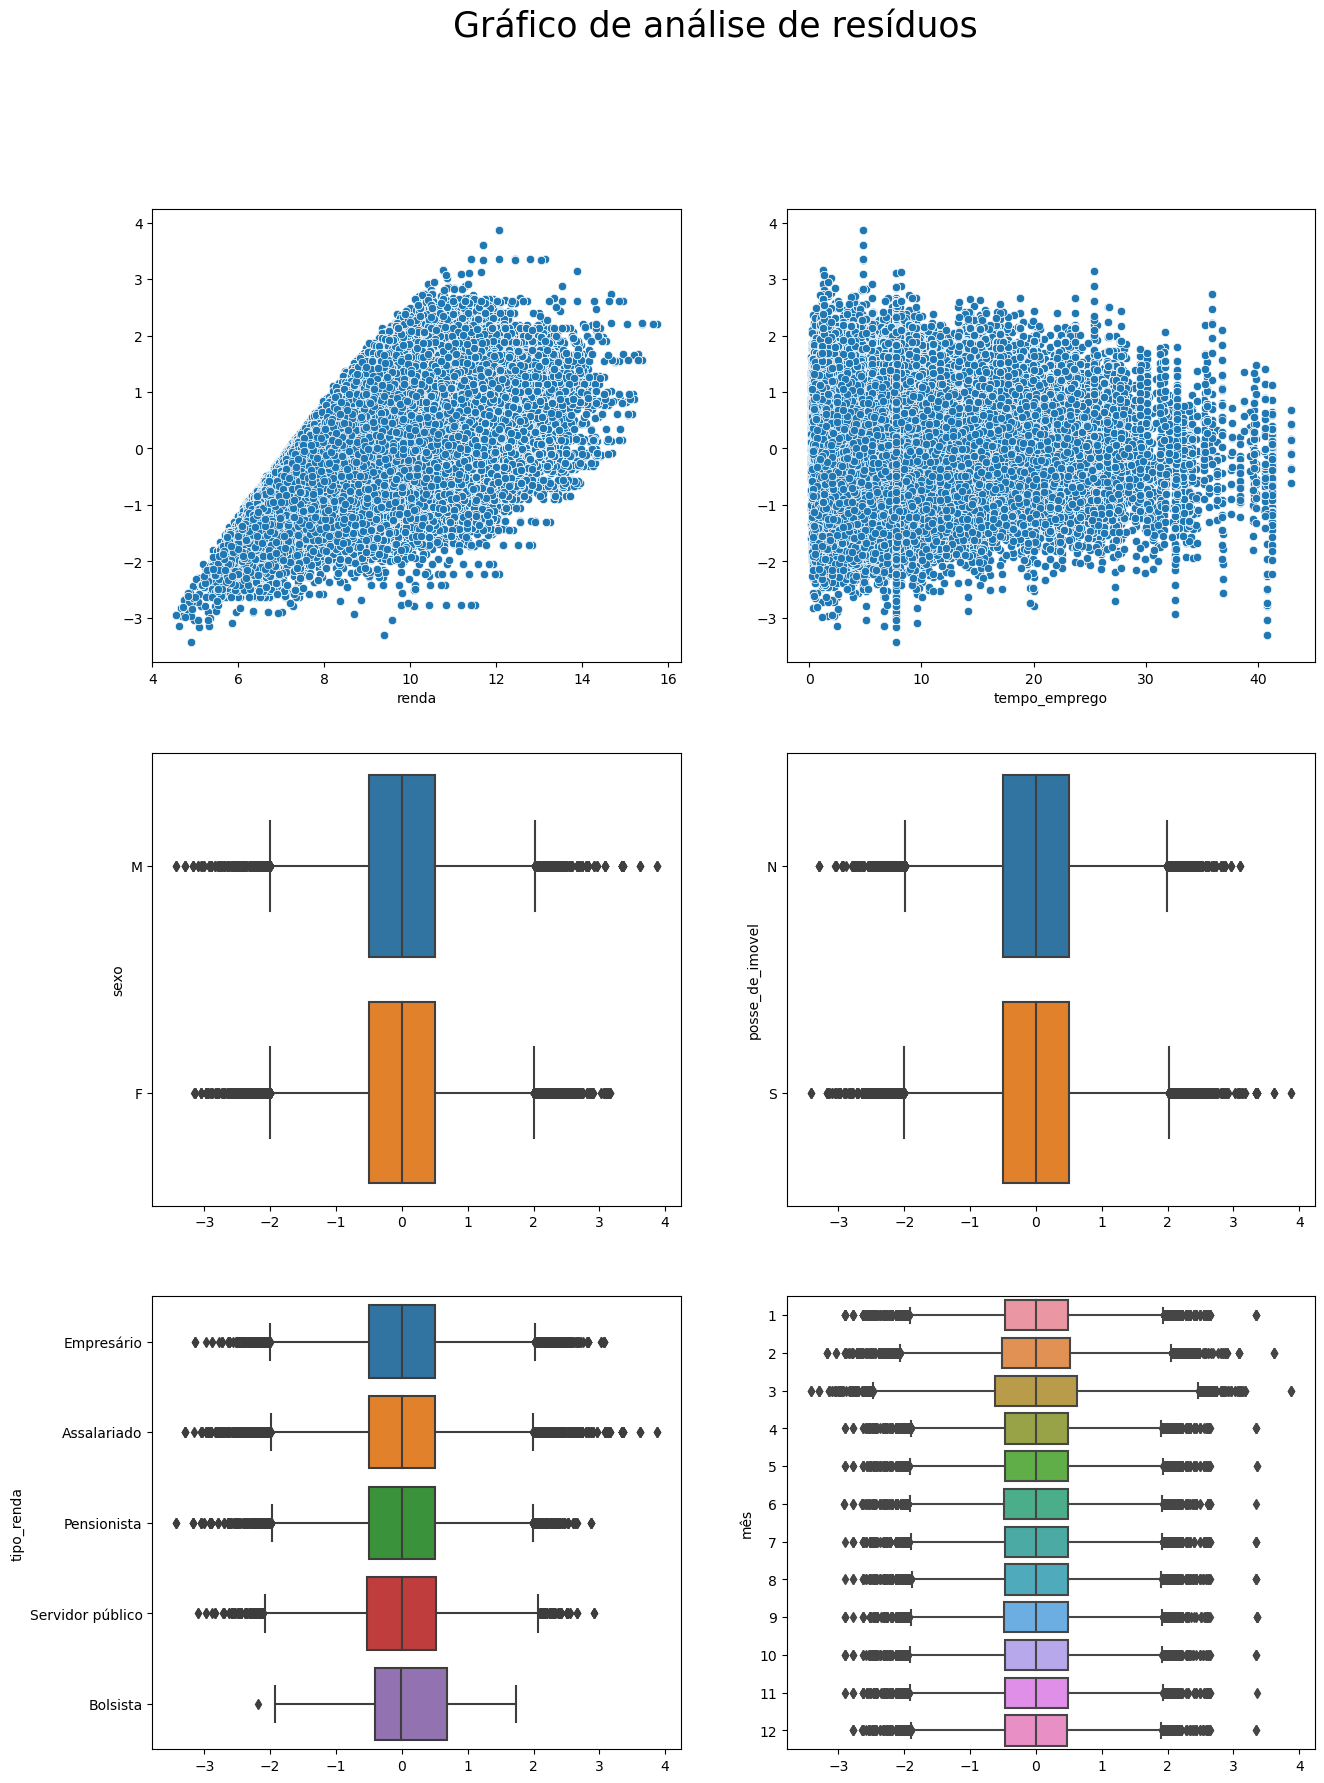

In [69]:
def residuos() -> None:
    # Ajustes
    figura = plt.figure(figsize=(15,20))
    figura.suptitle('Gráfico de análise de resíduos', fontsize=25)
    tamanho = (3,2)
    # Axis 1 (Commparação Resíduos x Real)
    ax = plt.subplot2grid(
        tamanho,
        (0,0)
    )
    
    fig = sns.scatterplot(y=m.resid, x=df['renda'], ax=ax)

    
    # Axis 2 (Resíduo x Numérico)
    ax = plt.subplot2grid(
        tamanho,
        (0,1)
    )
    fig = sns.scatterplot(y=m.resid, x=df['tempo_emprego'], ax=ax)
    
    # Axis 3 (Resíduo x Categórico)
    cat = ['sexo','posse_de_imovel','tipo_renda','mês']
    count = 0
    for row in range(1,3,1):
        for col in range(2):
            ax = plt.subplot2grid(
                tamanho,
                (row,col)
            )

            fig = sns.boxplot(x=m.resid, y=df[cat[count]], ax=ax, orient='h')

            count += 1
                
    
    
residuos()




In [70]:
df['resid'] = m.resid
df.groupby('mês')[['resid']].mean()

,resid
mês,
1,2.025826e-12
2,-5.125581e-13
3,2.857774e-12
4,-4.881087e-12
5,-9.188133e-12
6,5.593289e-12
7,-3.594778e-12
8,1.403932e-12
9,7.599630e-12


In [81]:
resultado = pd.DataFrame()
resultado['renda'] = df['renda']
resultado['previsao'] = AvaliacaoInicial().predict()

In [85]:
resultado['renda'].var()

1.6491608871414165

In [84]:
resultado['previsao'].var()

1.085058451579531

In [86]:
m.resid.var()

0.5641024355615892

- Se for levado em consideração a homocedasticidade dos dados, que diz a respeito da igualdade da variância ao dercorrer dos resíduos, vemos que ainda há muita informação não capitada pelo modelo, até devido a sua simplicidade.

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

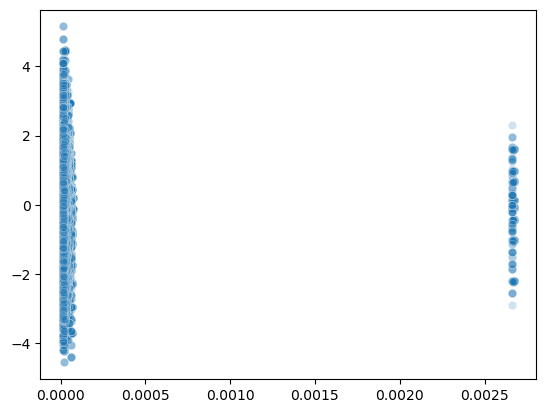

CPU times: total: 17.4 s
Wall time: 12.2 s


In [120]:
%%time
r_s = AvaliacaoInicial().influencia()

In [115]:
df['lev'] = r_s


In [118]:
df.loc[df['lev'] > 0.0025].shape

(377, 18)

- Pela grande quantidade de dados não é possível fazer uma avaliação muito satisfatória para a localização de todos os elementos que podem ser outliers, mas podemos misturar o leverage com um range studentized residuals para eliminar possíveis dados fora do padrão.

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

In [141]:
class Correlacao:
    def __init__(self):
        self.data = AvaliacaoInicial().data
    
    def spearman(self):
        # Passa o dado como correlação
        df_matrix = self.data.copy()
        for col in df_matrix.select_dtypes(exclude=np.number):
            df_matrix[col] = LabelEncoder().fit_transform(df_matrix[col])

        df_matrix = df_matrix.loc[:,['tempo_emprego','sexo','posse_de_imovel','tipo_renda','mês']]
        df_matrix = df_matrix.corr(method='spearman')

        # transforma os valores no intervalo em 0

        # Passar o formato triângular para vficar melhor a visualização do heatmap
        mask = np.triu(np.ones_like(df_matrix, dtype=bool))

        # Plotar o gráfico
        plt.figure(figsize=(15,8))

        fig = sns.heatmap(df_matrix, mask=mask, annot=True, cbar=False)
        fig.set_xticklabels(fig.get_xticklabels(), rotation=45) #Faz a rotação de 45 no x
        return plt.show()
    
    def VIF(self):
        df_dum = self.data.copy()
        df_dum = df_dum.loc[:,['tempo_emprego','sexo','posse_de_imovel','tipo_renda','mês']]
        variaveis = ['sexo','posse_de_imovel','tipo_renda','mês']
        df_dum = pd.get_dummies(df_dum[variaveis],drop_first=True)
        for col in df_dum.select_dtypes(exclude=np.number):
            df_dum[col] = LabelEncoder().fit_transform(df_dum[col])
        #return df_dum
        # Para saber o de todos.
        vars_vif = pd.DataFrame()
        vars_vif['VIF Factor'] = [vif(df_dum, i) for i in range(df_dum.shape[1])]
        vars_vif['Feature'] = df_dum.columns

        return vars_vif
    


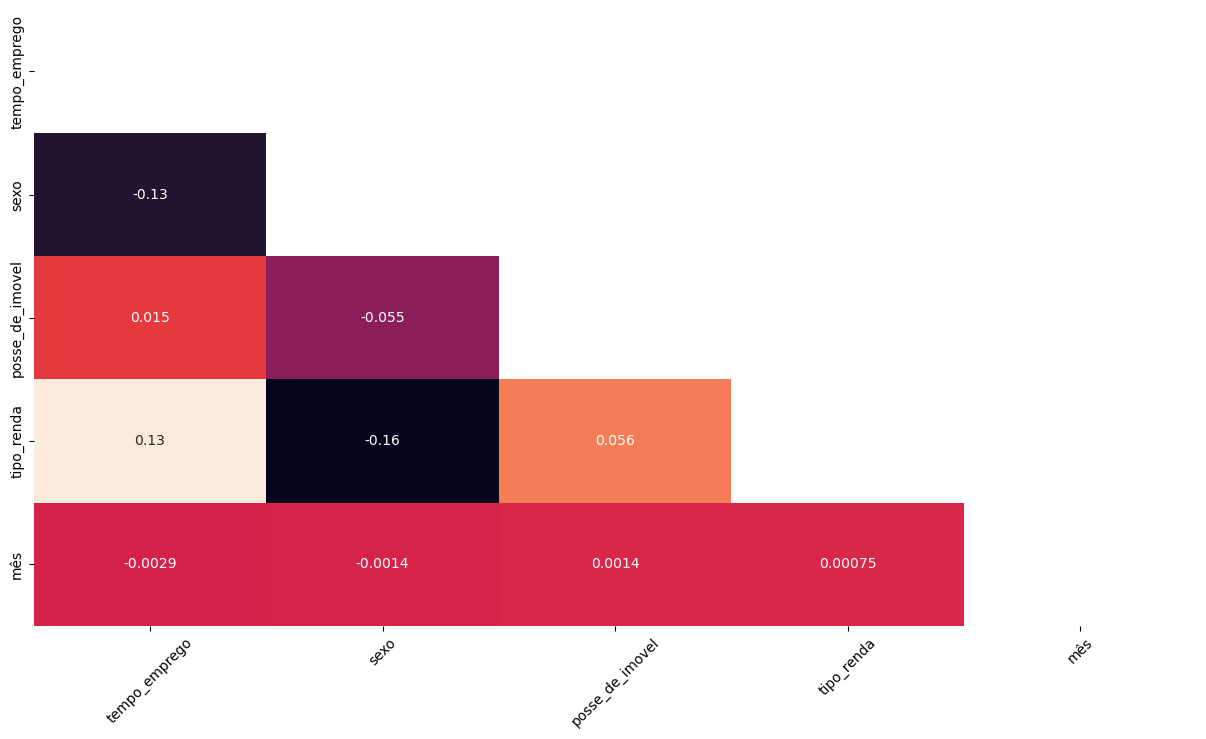

In [130]:
Correlacao().spearman()

In [142]:
Correlacao().VIF()

,VIF Factor,Feature
0,2.258888,mês
1,1.367871,sexo_M
2,2.204675,posse_de_imovel_S
3,1.001456,tipo_renda_Bolsista
4,1.319571,tipo_renda_Empresário
5,1.286135,tipo_renda_Pensionista
6,1.115253,tipo_renda_Servidor público


- Como só estamos usando uma variável numérica (tempo_emprego) a única forma de avaliar uma correlação entre os elementos categóricos com ela seria por um spearman e vemos que os valores permaneceram abaixo de 0.2, significando uma correlação muito abaixo.
- Analisando o VIF para ver a correlação dos dados categóricos, vemos que também não há correlação entre os dados.